# Fine-tune a large Dyula to French model

The purpose of the model is generate synthetic training data through back-translation.

## Setup environment

Restart the kernel after you have installed packages with `pip install` in the Notebook cell below.

In [1]:
!pip install -q -U sentencepiece transformers datasets sacrebleu lxml sentence-transformers accelerate fastai

In [2]:
HFHUB_LOGIN = False
LOAD_LOCAL_DATA = True

In [3]:
if HFHUB_LOGIN:
    from huggingface_hub import notebook_login
    notebook_login(new_session=False)

## Imports, config, etc

In [4]:
from functools import partial
from datasets import load_dataset
from transformers import AutoModelForSeq2SeqLM, NllbTokenizer
from fastai.callback.training import GradientAccumulation

from data import (
    load_from_json,
    TranslationDataset,
    create_dataloaders,
    save_data_locally,
    ds2df
)
from modeling import (
    load_model,
    create_learner
)
from utils import preproc, set_seed
from translation import translate
from evaluation import calculate_bleu

In [5]:
SRC_LANG = "dyu"
TGT_LANG = "fr"

MODEL_ID = "facebook/nllb-200-distilled-600M"
TOKENIZER_ID = "tokenizers/tokenizer_freq1"
RANDOM_SEED = 7  # Set `RANDOM_SEED = None` to run without a seed
MODEL_SAVE_PATH = 'saved_models/dyu-fra-600M'

In [6]:
if RANDOM_SEED is not None:
    set_seed(RANDOM_SEED, reproducible=True)

src_lang_code = "dyu_Latn" if SRC_LANG == "dyu" else "fra_Latn"
tgt_lang_code = "dyu_Latn" if TGT_LANG == "dyu" else "fra_Latn"
print(f"Translation from {src_lang_code} -> {tgt_lang_code}")

Translation from dyu_Latn -> fra_Latn


## Load data

In [7]:
if LOAD_LOCAL_DATA:
    df = load_from_json(
        train_files="data/dataset_train.json",
        valid_files="data/dataset_validation.json",
        test_files="data/dataset_test.json",
        return_format="df"
    )
else:
    ds = load_dataset("uvci/Koumankan_mt_dyu_fr")
    save_data_locally(ds, save_dir="./data")
    df = ds2df(ds)
print(df.shape)
df.head()

(10929, 3)


,dyu,fr,split
0,A bi ji min na,Il boit de l’eau.,train
1,A le dalakolontɛ lon bɛ.,Il se plaint toujours.,train
2,Mun? Fɛn dɔ.,Quoi ? Quelque chose.,train
3,O bɛ bi bɔra fo Gubeta.,Tous sortent excepté Gubetta.,train
4,A ale lo bi da bugɔ la!,Ah ! c’est lui… il sonne…,train


In [8]:
df_train = df[df["split"] == "train"].copy()
df_valid = df[df["split"]== "validation"].copy()
df_test = df[df["split"]== "test"].copy()
assert len(df_train) + len(df_valid) + len(df_test) == len(df)

## Load model

In [9]:
model, tokenizer = load_model(
    MODEL_ID, tokenizer_id=TOKENIZER_ID, load_tokenizer=True, remap_embeddings=True,
    init_embeds_for_new_tokens=True, src_language=src_lang_code, tgt_language=tgt_lang_code,
)
print(f"Memory footprint: {model.get_memory_footprint() / 1024**3 :.2f}GB")

/usr/local/lib/python3.11/dist-packages/torch/_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()
/usr/local/lib/python3.11/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


Number of tokens w/o embeddings: 1
model.shared.weight torch.Size([256206, 1024])
model.encoder.embed_tokens.weight torch.Size([256206, 1024])
model.decoder.embed_tokens.weight torch.Size([256206, 1024])
lm_head.weight torch.Size([256206, 1024])
Memory footprint: 1.36GB
Memory footprint: 1.36GB


Calculate the BLEU score for French-Dyula translation before fine-tuning:

In [10]:
translate_func = partial(
    translate, model=model, tokenizer=tokenizer, src_lang=src_lang_code, tgt_lang=tgt_lang_code
)
calculate_bleu(
    model, df_valid[[SRC_LANG, TGT_LANG]], translate_func, src_lang=src_lang_code, tgt_lang=tgt_lang_code,
    preproc_func=preproc
)

  0%|          | 0/1471 [00:00<?, ?it/s]

4.440538477725872

## Create dataloader

The `create_dataloaders` function expects the source language to be in the first columns of the dataframe and the target language in the second.

We will train in small batches and use gradient accumulation.

In [11]:
bs, validation_bs = 16, 128
dls = create_dataloaders(
    df_train[[SRC_LANG, TGT_LANG]], df_valid[[SRC_LANG, TGT_LANG]], tokenizer, bs=bs,
    src_lang=src_lang_code, tgt_lang=tgt_lang_code, preproc_func=preproc,
    max_length=128, validation_bs=validation_bs
)

## Train

In [12]:
learn = create_learner(
    dls, model, tokenizer, src_lang=src_lang_code, tgt_lang=tgt_lang_code, #wd=1e-3
)#.to_fp16()

We use Fastai's handy learning rate finder to pick a reasonable learning rate:

SuggestedLRs(valley=0.00019054606673307717)

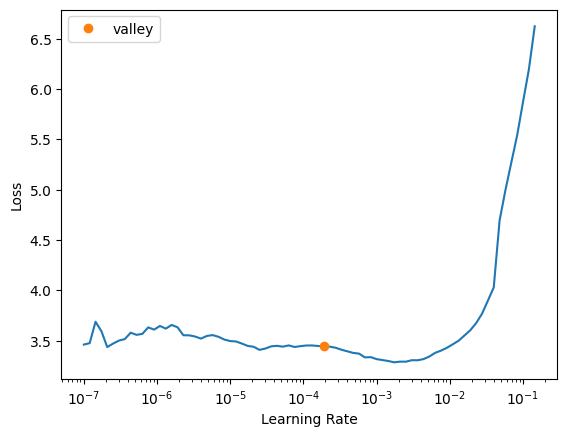

In [13]:
learn.lr_find()

In [14]:
accum_steps = max(1, 32//bs)
learn.fit_one_cycle(10, 5e-5, cbs=GradientAccumulation(accum_steps))

epoch,train_loss,valid_loss,BLEU,time
0,2.849640,2.704612,7.051076,01:13
1,2.367163,2.413182,8.185398,01:13
2,1.975298,2.281183,9.867670,01:13
3,1.734720,2.287261,10.913720,01:13
4,1.505391,2.302378,11.471910,01:13
5,1.371027,2.321306,11.339179,01:13
6,1.264625,2.361407,11.871267,01:13
7,1.187738,2.381838,11.865291,01:13
8,1.123053,2.395090,11.648493,01:13
9,1.119252,2.398659,11.712085,01:13


Calculate the BLEU score for French-Dyula translation after fine-tuning:

In [15]:
calculate_bleu(
    model, df_valid, translate_func, src_lang=src_lang_code, tgt_lang=tgt_lang_code,
    preproc_func=preproc
)

  0%|          | 0/1471 [00:00<?, ?it/s]

11.732053472866868

In [16]:
model.save_pretrained(MODEL_SAVE_PATH)
tokenizer.save_pretrained(MODEL_SAVE_PATH)

[2024-08-29 21:30:08,448] [INFO] [real_accelerator.py:158:get_accelerator] Setting ds_accelerator to cuda (auto detect)


Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 200}


('saved_models/dyu-fra-600M/tokenizer_config.json',
 'saved_models/dyu-fra-600M/special_tokens_map.json',
 'saved_models/dyu-fra-600M/sentencepiece.bpe.model',
 'saved_models/dyu-fra-600M/added_tokens.json')